# Chargrid
It is an end-to-end trainable approach for Optical Character Recognition (OCR) on printed documents.
Specifically, it is  a model that predicts a) a twodimensional character grid (chargrid) representation of a
document image as a semantic segmentation task and b)
character boxes for delineating character instances as an
object detection task. For training the model, the authors have   also build two large-scale datasets without resorting to any manual
annotation - synthetic documents with clean labels and
real documents with noisy labels. They have also demonstrated experimentally that this method, trained on the combination of
these datasets, (i) outperforms previous state-of-the-art approaches in accuracy (ii) is easily parallelizable on GPU
and is, therefore, significantly faster and (iii) is easy to train
and adapt to a new domain


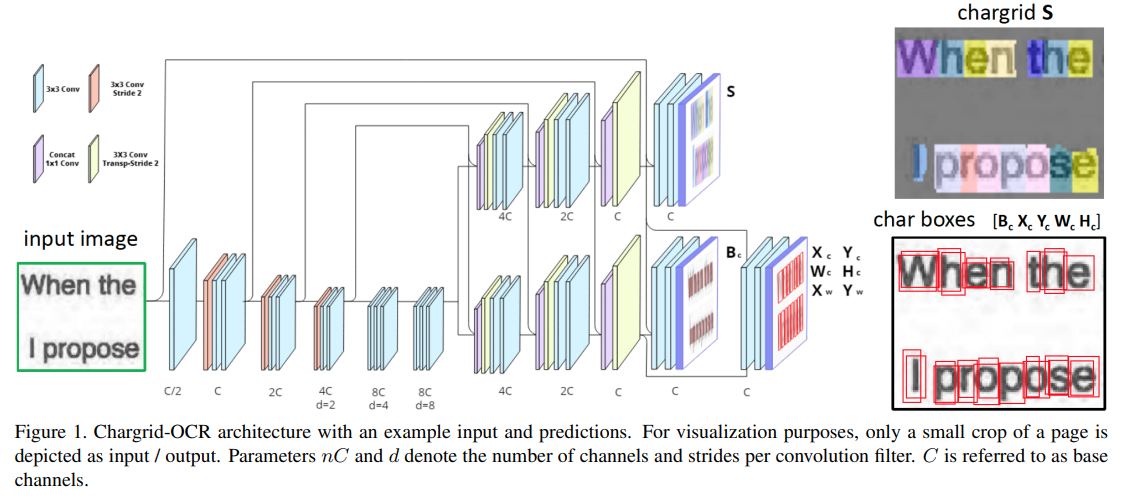

# Importing Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import torchvision
from PIL import Image
from torchsummary import summary
from skimage.transform import resize
from torch.utils.data import Dataset, random_split
from google.colab.patches import cv2_imshow
from __future__ import print_function, division
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preprocessing and Loading

In [2]:
width = 128
height = 256
nb_classes = 5
nb_anchors = 4  # one per foreground class
input_channels = 61
base_channels = 64
batch_size = 64

pad_left_range = 0.2
pad_top_range = 0.2
pad_right_range = 0.2
pad_bot_range = 0.2
dir_np_chargrid_1h = "/content/drive/MyDrive/new_chargrid/Chargrid/np_chargrid_1h/"
dir_np_gt_1h = "/content/drive/MyDrive/new_chargrid/Chargrid/np_gt_1h/" 
dir_np_bbox_anchor_mask = "/content/drive/MyDrive/new_chargrid/Chargrid/np_bbox_anchor_mask/" 
dir_np_bbox_anchor_coord = "/content/drive/MyDrive/new_chargrid/Chargrid/np_bbox_anchor_cooord/"

In [3]:
list_filenames = [
    f
    for f in os.listdir(dir_np_chargrid_1h)
    if os.path.isfile(os.path.join(dir_np_chargrid_1h, f))
]
b = list_filenames[:500]

In [4]:
def augment_data(data, tab_rand, order, shape, coord=False):
    data_temp = resize(
        np.pad(
            data,
            ((tab_rand[1], tab_rand[3]), (tab_rand[0], tab_rand[2]), (0, 0)),
            "constant",
        ),
        shape,
        order=order,
        anti_aliasing=True,
    )

    if coord:
        for i in range(0, nb_anchors):
            mask = (data_temp > 1e-6)[:, :, 4 * i]
            data_temp[mask, 4 * i] *= shape[1]
            data_temp[mask, 4 * i] += tab_rand[0]
            data_temp[mask, 4 * i] /= tab_rand[0] + shape[1] + tab_rand[2]

            data_temp[mask, 4 * i + 2] *= shape[1]
            data_temp[mask, 4 * i + 2] += tab_rand[0]
            data_temp[mask, 4 * i + 2] /= tab_rand[0] + shape[1] + tab_rand[2]

            data_temp[mask, 4 * i + 1] *= shape[0]
            data_temp[mask, 4 * i + 1] += tab_rand[1]
            data_temp[mask, 4 * i + 1] /= tab_rand[1] + shape[0] + tab_rand[3]

            data_temp[mask, 4 * i + 3] *= shape[0]
            data_temp[mask, 4 * i + 3] += tab_rand[1]
            data_temp[mask, 4 * i + 3] /= tab_rand[1] + shape[0] + tab_rand[3]

    return data_temp


def extract_combined_data(
    dataset, batch_size, pad_left_range, pad_top_range, pad_right_range, pad_bot_range
):
    if batch_size > len(dataset):
        raise ValueError("batch_size > length of dataset {}".format(len(dataset)))

    np.random.shuffle(dataset)
    tab_rand = np.random.rand(batch_size, 4) * [
        pad_left_range * width,
        pad_top_range * height,
        pad_right_range * width,
        pad_bot_range * height,
    ]

    tab_rand = tab_rand.astype(int)
    chargrid_input, seg_gt, anchor_mask_gt, anchor_coord_gt = [], [], [], []

    for i in range(0, batch_size):
        data = np.load(os.path.join(dir_np_chargrid_1h, dataset[i]))
        chargrid_input.append(data)
        # chargrid_input.append(augment_data(data, tab_rand[i], order=1, shape=(height, width, input_channels)))

        data = np.load(os.path.join(dir_np_gt_1h, dataset[i]))
        seg_gt.append(data)
        # seg_gt.append(augment_data(data, tab_rand[i], order=1, shape=(height, width, nb_classes)))

        data = np.load(os.path.join(dir_np_bbox_anchor_mask, dataset[i]))
        anchor_mask_gt.append(data)
        # anchor_mask_gt.append(augment_data(data, tab_rand[i], order=1, shape=(height, width, 2 * nb_anchors)))

        data = np.load(os.path.join(dir_np_bbox_anchor_coord, dataset[i]))
        anchor_coord_gt.append(data)
        # anchor_coord_gt.append(
        #     augment_data(data, tab_rand[i], order=0, shape=(height, width, 4 * nb_anchors), coord=True))

    return (
        np.array(chargrid_input),
        np.array(seg_gt),
        np.array(anchor_mask_gt),
        np.array(anchor_coord_gt),
    )


In [6]:
time_then = datetime.now()
# print(time_then)

# Extract combined data here
chargrid_input, seg_gt, anchor_mask_gt, anchor_coord = extract_combined_data(
    b,
    batch_size,
    pad_left_range,
    pad_top_range,
    pad_right_range,
    pad_bot_range,
)
print(len(chargrid_input))

print("total time taken for file parsing: ")
print((datetime.now() - time_then).total_seconds())

64
total time taken for file parsing: 
156.438956


# Model

In [7]:
class ChargridDataset(Dataset):
    def __init__(
        self,
        chargrid_input,
        segmentation_ground_truth,
        anchor_mask_ground_truth,
        anchor_coordinates,
    ):
        self.chargrid_input = chargrid_input
        self.segmentation_ground_truth = segmentation_ground_truth
        self.anchor_mask_ground_truth = anchor_mask_ground_truth
        self.anchor_coordinates = anchor_coordinates
        return

    def __len__(self):
        return len(self.chargrid_input)

    def __getitem__(self, idx):
        if type(idx) is torch.Tensor:
            index = idx.item()

        segmentation_label = self.segmentation_ground_truth[idx]
        anchor_mask_label = self.anchor_mask_ground_truth[idx]
        anchor_coordinates_label = self.anchor_coordinates[idx]
        image = Image.fromarray(
            np.uint8(np.squeeze(self.chargrid_input[idx, :, :, 0:3] * 255))
        )

        transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

        return (
            transforms(image),
            transforms(segmentation_label),
            transforms(anchor_mask_label),
            transforms(anchor_coordinates_label),
        )


def get_dataset():
    dataset = ChargridDataset(chargrid_input, seg_gt, anchor_mask_gt, anchor_coord)
    # print('Dataset length is {0}'.format(len(dataset)))
    test_no = int(len(dataset) * 0.2)
    trainset, testset = random_split(dataset, [len(dataset) - test_no, test_no])

    # print(len(trainset), len(testset))

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=10, shuffle=True, num_workers=8
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=len(testset), shuffle=True, num_workers=8
    )

    return trainloader, testloader

In [8]:
def add_block_a(inputs, outputs, s=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=inputs, out_channels=outputs, stride=s, kernel_size=3, padding=1
        ),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Dropout(p=0.1),
    )


def add_block_a_dash(inputs, outputs):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=inputs, out_channels=outputs, stride=2, kernel_size=3, padding=1
        ),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(
            in_channels=outputs,
            out_channels=outputs,
            kernel_size=3,
            padding=1,
            dilation=1,
        ),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(
            in_channels=outputs,
            out_channels=outputs,
            kernel_size=3,
            padding=1,
            dilation=1,
        ),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Dropout(p=0.1),
    )


def add_block_a_double_dash(inputs, outputs, d):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=inputs,
            out_channels=outputs,
            kernel_size=3,
            padding=1,
            dilation=d,
        ),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(
            in_channels=outputs,
            out_channels=outputs,
            kernel_size=3,
            padding=1,
            dilation=d,
        ),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(
            in_channels=outputs,
            out_channels=outputs,
            kernel_size=3,
            padding=1,
            dilation=d,
        ),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Dropout(p=0.1),
    )


def add_block_b(inputs, outputs):
    return nn.Sequential(
        nn.Conv2d(in_channels=inputs, out_channels=outputs, stride=2, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.ConvTranspose2d(
            in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1
        ),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Dropout(p=0.1),
    )


def add_block_c(inputs, outputs):
    return nn.Sequential(
        nn.Conv2d(in_channels=inputs, out_channels=outputs, stride=2, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.ConvTranspose2d(
            in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1
        ),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
    )


def add_block_d_or_e(inputs, outputs):
    return nn.Sequential(
        nn.Conv2d(in_channels=inputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Softmax(dim=1),
    )


def add_block_f(inputs, outputs):
    return nn.Sequential(
        nn.Conv2d(in_channels=inputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
        # nn.Linear(in_features=inputs, out_features=outputs),
    )


def concatenate_tensors(tensor1, tensor2):
    diff_height = tensor2.size()[2] - tensor1.size()[2]
    diff_width = tensor2.size()[3] - tensor1.size()[3]

    tensor1 = F.pad(
        tensor1,
        [
            diff_width // 2,
            diff_width - diff_width // 2,
            diff_height // 2,
            diff_height - diff_height // 2,
        ],
    )
    return torch.cat([tensor1, tensor2], dim=1)


def shape_as_string(shape):
    return str(list(shape))


class ChargridNetwork(nn.Module):
    def __init__(self, HW, C, num_classes=5, num_anchors=4):
        super(ChargridNetwork, self).__init__()

        """
        Encoder definition
        """
        self.first_a_block = add_block_a(HW, C, 1)
        self.second_a_block = add_block_a(C, 2 * C, 2)
        self.a_dash_block = add_block_a_dash(2 * C, 4 * C)
        self.first_a_double_dash_block = add_block_a_double_dash(4 * C, 8 * C, d=2)
        self.second_a_double_dash_block = add_block_a_double_dash(8 * C, 8 * C, d=4)

        """
        Semantic Segmentation Decoder (ssd)
        """
        self.ssd_first_b_block = add_block_b(12 * C, 4 * C)
        self.ssd_second_b_block = add_block_b(6 * C, 2 * C)
        self.ssd_c_block = add_block_c(3 * C, C)
        self.ssd_d_block = add_block_d_or_e(C, num_classes)
        self.upsample = nn.Upsample(scale_factor=2)

        """
        Bounding Box Regression Decoder (bbrd)
        """

        self.bbrd_first_b_block = add_block_b(12 * C, 4 * C)
        self.bbrd_second_b_block = add_block_b(6 * C, 2 * C)
        self.bbrd_c_block = add_block_c(3 * C, C)
        self.bbrd_e_block = add_block_d_or_e(C, 2 * num_anchors)
        self.bbrd_f_block = add_block_f(C, 4 * num_anchors)

    def forward(self, x):
        """
        Forward pass function for the network
        :param x:
        :return:
        """

        """
        Forward pass through Encoder
        """
        # print("input shape " + shape_as_string(x.shape))

        first_a_block_output = self.first_a_block(x)
        # print("after first a block " + shape_as_string(first_a_block_output.shape))

        second_a_block_output = self.second_a_block(first_a_block_output)
        # print("after second a block " + shape_as_string(second_a_block_output.shape))

        a_dash_block_output = self.a_dash_block(second_a_block_output)
        # print("after a dash block " + shape_as_string(a_dash_block_output.shape))

        first_a_double_dash_block_output = self.first_a_double_dash_block(
            a_dash_block_output
        )
        # print("after first a double dash block " + shape_as_string(first_a_double_dash_block_output.shape))

        second_a_double_dash_block_output = self.second_a_double_dash_block(
            first_a_double_dash_block_output
        )
        # print("after second a double dash block " + shape_as_string(second_a_double_dash_block_output.shape))

        """
        Forward pass through semantic segmentation decoder
        """
        ssd_first_b_block_input = concatenate_tensors(
            second_a_double_dash_block_output, a_dash_block_output
        )
        ssd_first_b_block_output = self.ssd_first_b_block(ssd_first_b_block_input)
        # print("ssd after first b block " + shape_as_string(ssd_first_b_block_output.shape))

        ssd_second_b_block_input = concatenate_tensors(
            ssd_first_b_block_output, second_a_block_output
        )
        ssd_second_b_block_output = self.ssd_second_b_block(ssd_second_b_block_input)
        # print("ssd after second b block " + shape_as_string(ssd_second_b_block_output.shape))

        ssd_c_block_input = concatenate_tensors(
            ssd_second_b_block_output, first_a_block_output
        )
        ssd_c_block_output = self.ssd_c_block(ssd_c_block_input)
        # print("ssd after c block " + shape_as_string(ssd_c_block_output.shape))

        d_block_output = self.ssd_d_block(ssd_c_block_output)
        d_block_output = self.upsample(d_block_output)
        # print("ssd after d block " + shape_as_string(d_block_output.shape))

        """
        Forward pass through bounding box regression decoder
        """
        bbrd_first_b_block_input = concatenate_tensors(
            second_a_double_dash_block_output, a_dash_block_output
        )
        bbrd_first_b_block_output = self.bbrd_first_b_block(bbrd_first_b_block_input)
        # print("bbrd after first b block " + shape_as_string(bbrd_first_b_block_output.shape))

        bbrd_second_b_block_input = concatenate_tensors(
            bbrd_first_b_block_output, second_a_block_output
        )
        bbrd_second_b_block_output = self.bbrd_second_b_block(bbrd_second_b_block_input)
        # print("bbrd after second b block " + shape_as_string(bbrd_second_b_block_output.shape))

        bbrd_c_block_input = concatenate_tensors(
            bbrd_second_b_block_output, first_a_block_output
        )
        bbrd_c_block_output = self.bbrd_c_block(bbrd_c_block_input)
        # print("bbrd after c block " + shape_as_string(bbrd_c_block_output.shape))

        bbrd_e_block_output = self.bbrd_e_block(bbrd_c_block_output)
        bbrd_e_block_output = self.upsample(bbrd_e_block_output)
        # print("bbrd after e block " + shape_as_string(bbrd_e_block_output.shape))

        bbrd_f_block_output = self.bbrd_f_block(bbrd_c_block_output)
        bbrd_f_block_output = self.upsample(bbrd_f_block_output)
        # print("bbrd after f block " + shape_as_string(bbrd_f_block_output.shape))

        return d_block_output, bbrd_e_block_output, bbrd_f_block_output


In [9]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.uniform_(m.weight, a=0.0, b=1.0)


def init_weights_in_last_layers(net):
    torch.nn.init.constant_(net.ssd_d_block[6].weight, 1e-3)
    torch.nn.init.constant_(net.bbrd_e_block[6].weight, 1e-3)
    torch.nn.init.constant_(net.bbrd_f_block[6].weight, 1e-3)


# Model Training

In [11]:
device = torch.device("cuda")
torch.manual_seed(0)

HW = 3
C = 64
num_classes = 5
num_anchors = 4

trainloader, testloader = get_dataset()

net = ChargridNetwork(3, 64, 5, 4)
if torch.cuda.device_count() > 1:
        print("Found " + str(torch.cuda.device_count()) + " gpus")
        print("Applying data parallel processing")
        net = nn.DataParallel(net)
net = net.apply(init_weights)
init_weights_in_last_layers(net)
net = net.to(device)
model_dir = "/content/drive/MyDrive/chagrid/model_save"

loss1 = nn.BCELoss()
loss2 = nn.BCELoss()
loss3 = nn.SmoothL1Loss()

    # Observe that all parameters are being optimized
optimizer_ft = optim.SGD(net.to(device).parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
losses = {"loss1": [], "loss2": [], "loss3": [], "combined_losses": []}

num_epochs = 7
for epoch in range(num_epochs):
        final_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            for inputs, label1, label2, label3 in trainloader:
                inputs = inputs.to(device)
                label1 = label1.to(device)
                label2 = label2.to(device)
                label3 = label3.to(device)

                optimizer_ft.zero_grad()
                output1, output2, output3 = net(inputs)

                loss_1 = loss1(output1, label1.float())
                # print(loss_1)
                losses["loss1"].append(loss_1)

                loss_2 = loss2(output2, label2.float())
                # print(loss_2)
                losses["loss2"].append(loss_2)

                loss_3 = loss3(output3, label3.float())
                # print(loss_3)
                losses["loss3"].append(loss_3)

                final_loss = loss_1 + loss_2 + loss_3
                losses["combined_losses"].append(final_loss)
                final_loss.backward()
                optimizer_ft.step()

                # _, predicted1 = torch.max(output1.squeeze(), dim=0)
                # total1 += label1.size(0)

            exp_lr_scheduler.step()
        
         #   print("Epoch {}/{}, Loss1: {:.3f},Loss2: {:.3f}".format(epoch, num_epochs, loss_1,loss_2,loss_3))
        print("Epoch {}/{}, Loss: {:.3f}".format(epoch, num_epochs, final_loss.item()))

        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": net.state_dict(),
                "optimizer_state_dict": optimizer_ft.state_dict(),
                "loss": losses,
            },
            os.path.join(model_dir, "new_epoch-{}.pt".format(epoch)),
        )

print("================")
print("================")
print("loss1: " + str(losses["loss1"]))
print("loss2: " + str(losses["loss2"]))
print("loss3: " + str(losses["loss3"]))
print("combined: " + str(losses["combined_losses"]))
print("Finished Training")

Epoch 0/7, Loss: 1.652
Epoch 1/7, Loss: 1.645
Epoch 2/7, Loss: 1.646
Epoch 3/7, Loss: 2.242
Epoch 4/7, Loss: 2.197
Epoch 5/7, Loss: 2.205
Epoch 6/7, Loss: 2.204
loss1: [tensor(0.6170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), tensor(0.9499, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), tensor(0.9496, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), tensor(0.7219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), tensor(0.9437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), tensor(0.5002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), tensor(0.9440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), tensor(0.4998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), tensor(0.7217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), tensor(1.0602, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), tensor(0.9491, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), tensor(0.5283, device='cuda:0', grad_fn

In [12]:
mnet = ChargridNetwork(3, 64, 5, 4)
mnet = mnet.to(device)
summary(mnet, input_size=(3, 256, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 128]           1,792
         LeakyReLU-2         [-1, 64, 256, 128]               0
       BatchNorm2d-3         [-1, 64, 256, 128]             128
            Conv2d-4         [-1, 64, 256, 128]          36,928
         LeakyReLU-5         [-1, 64, 256, 128]               0
       BatchNorm2d-6         [-1, 64, 256, 128]             128
            Conv2d-7         [-1, 64, 256, 128]          36,928
         LeakyReLU-8         [-1, 64, 256, 128]               0
       BatchNorm2d-9         [-1, 64, 256, 128]             128
          Dropout-10         [-1, 64, 256, 128]               0
           Conv2d-11         [-1, 128, 128, 64]          73,856
        LeakyReLU-12         [-1, 128, 128, 64]               0
      BatchNorm2d-13         [-1, 128, 128, 64]             256
           Conv2d-14         [-1, 128, 

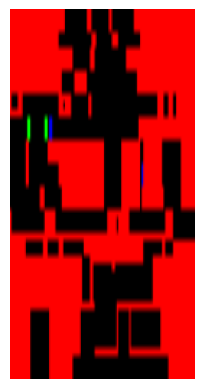

In [13]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

img_array = np.load("/content/drive/MyDrive/new_chargrid/Chargrid/np_chargrid_1h/X51006008197.npy")

image1 = Image.fromarray(np.uint8(np.squeeze(img_array[:, :, 0:3] * 255)))

plt.imshow(image1, cmap='gray')
image1.save("pred3.jpg")
plt.axis('off')
plt.show()

In [14]:
checkpoint = torch.load("/content/drive/MyDrive/chagrid/model_save/new_epoch-2.pt")
mnet.load_state_dict(checkpoint['model_state_dict'])
mnet.eval()

image2 = transforms(image1)
image3 = image2.unsqueeze(0)
output1, output2, output3 = mnet(image3.cuda())

print("Output1 shape: ",output1.shape) 
print("Output2 shape: ",output2.shape)
print("Output3 shape: ",output3.shape)

output1.cpu().data.numpy().argmax()
output2.cpu().data.numpy().argmax()
output3.cpu().data.numpy().argmax()

Output1 shape:  torch.Size([1, 5, 256, 128])
Output2 shape:  torch.Size([1, 8, 256, 128])
Output3 shape:  torch.Size([1, 16, 256, 128])


214078

In [ ]:
##output1=========================

preds1 = output1.cpu().data.numpy()

pred = np.squeeze(preds1)
print(pred.shape)

b = np.transpose(pred, (1, 2, 0))
print(b.shape)


pred = Image.fromarray(np.uint8(np.squeeze(b[:, :, 0:3] * 255)))

plt.imshow(pred)
plt.show()

In [ ]:
##output2========================

preds2 = output2.cpu().data.numpy()

pred3 = np.squeeze(preds2)
print(pred3.shape)

b1 = np.transpose(pred3, (1, 2, 0))

print(b1.shape)


pred4 = Image.fromarray(np.uint8(np.squeeze(b1[:, :, 0:3] * 255)))

plt.imshow(pred4, cmap='jet')
plt.show()

In [ ]:
###output3======================
preds5 = output3.cpu().data.numpy()

pred6 = np.squeeze(preds2)
print(pred6.shape)

b2 = np.transpose(pred6, (1, 2, 0))

print(b2.shape)


pred7 = Image.fromarray(np.uint8(np.squeeze(b2[:, :, 0:3] * 255)))


plt.imshow(pred7, cmap='jet')
plt.show()

In [ ]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(10,10))

# output1 and output2 
ax1.imshow(pred,cmap='jet')
ax2.imshow(pred4,cmap='jet')
pred.save('segmented.jpg')